In [1]:
from __future__ import division, unicode_literals, print_function # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.ndimage import shift

# change the following to %matplotlib notebook for interactive plotting
%matplotlib widget

# Optionally, tweak styles.
mpl.rc('figure', figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [2]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame, Series # for convenience

# import the packages for reading images and particle tracking
from skimage import io
import trackpy as tp

In [3]:
def crop(img):
    """
    Crop the image to select the region of interest
    """
    x_min = 0
    x_max = -1
    y_min = 0
    y_max = -1
    return img[y_min:y_max,x_min:x_max]

In [4]:
# Set the directory path
glacier_path = 'Z:\Mingxuan Liu'

# The folder where the .tif image stack exists
folder_name = '3steel&1copper_SteelUp_chiral_10_6fps'

# The file needed to be read
file_name = folder_name + ' binary crop.tif'

# Join the directory path, folder name, and file name to locate .tif images
tif_path = os.path.join(glacier_path, folder_name, file_name)

frames = io.imread(tif_path)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


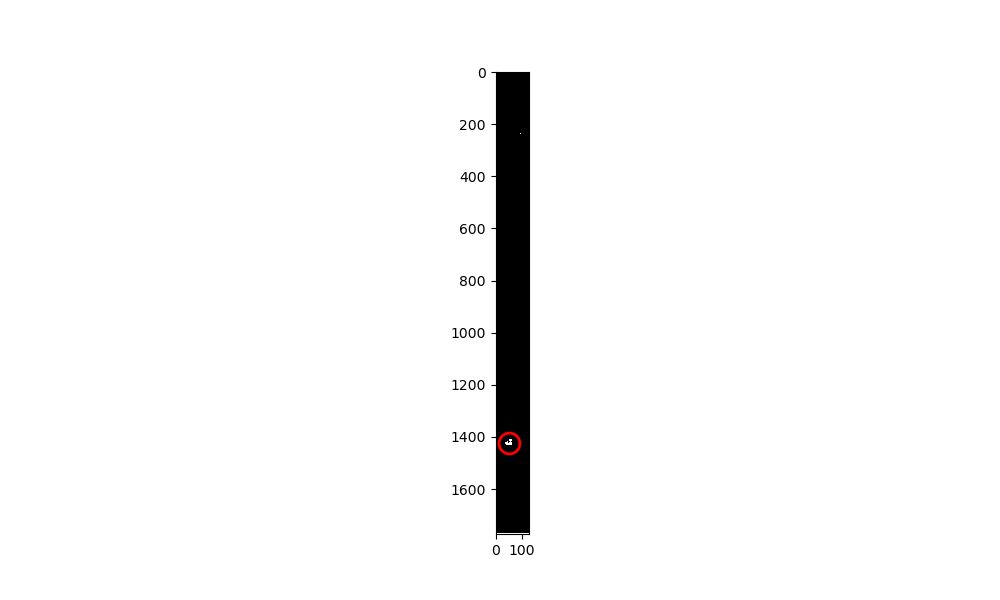

In [5]:
# manually check the binary cropped image
fr = 200
# tracking parameters
params = {
    'diameter': 43,
    'minmass': 3000,
    'invert': False,
    'separation': 15,
}
f = tp.locate(frames[fr], **params);
plt.figure()
image = tp.annotate(f, frames[fr]);

In [6]:
# process particle tracking for all frames
data = tp.batch(frames, **params);

Frame 247: 1 features


In [7]:
# Link the particles in each frame to their positions in previous two frames
link_data = tp.link(data,15,memory=3)

# Group by 'frame' and count the number of particles in each group
group_sizes = link_data.groupby('frame').size()
# Find frames where more than one particle is identified
more_particle_frames = group_sizes[group_sizes > 1]
# Print the frame numbers
print("Frames below have identified more than one particle:")
print(more_particle_frames.index.tolist())

Frame 247: 1 trajectories present.
Frames below have identified more than one particle:
[]


In [8]:
print(link_data)
link_data.to_csv(os.path.join(glacier_path, folder_name, folder_name + ' binary.csv'))

               y          x          mass       size       ecc      signal  \
0      33.886532  96.156134  82571.959639   9.513131  0.206076  200.910785   
1      40.479349  96.059160  81874.432836   9.546954  0.208984  200.771047   
2      47.361760  95.911017  81399.388769   9.435830  0.210399  201.221903   
3      54.295885  95.667030  82219.609173   9.567653  0.190124  200.495360   
4      61.249427  95.453388  81547.632767   9.519949  0.222061  199.436719   
..           ...        ...           ...        ...       ...         ...   
243  1716.362482  38.688912  74635.789896  10.394475  0.230740  202.762789   
244  1723.214681  38.532967  74226.509163   9.708739  0.301785  203.487103   
245  1729.991395  38.259398  75563.524836   9.796743  0.283698  202.154296   
246  1736.757255  37.932188  74319.992486   9.694001  0.287069  202.902942   
247  1743.393546  37.759138  73898.687522   9.634406  0.300130  202.762789   

     raw_mass   ep  frame  particle  
0    117555.0  0.0      0

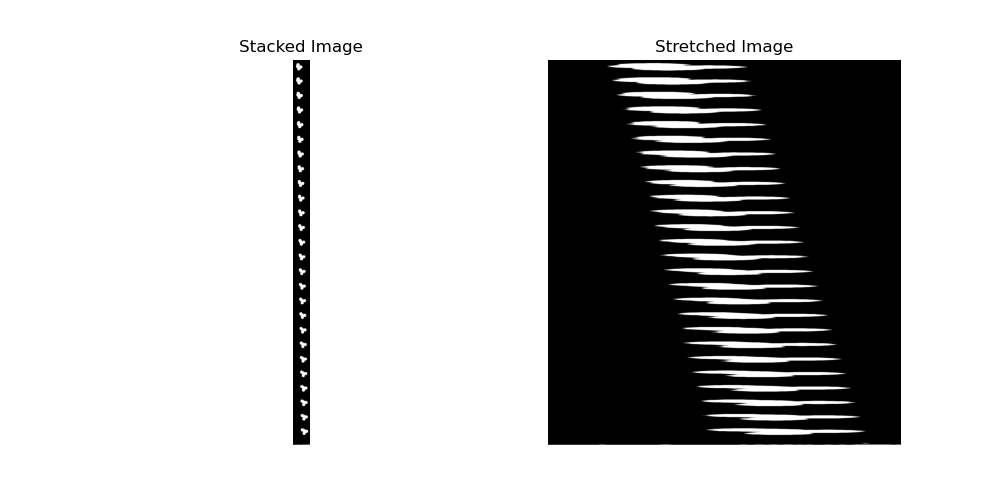

In [10]:
# Number of total frames
total_frames = frames.shape[0]

# Calculate the interval at which to take slices
interval = total_frames // 25

# Select 15 evenly distributed slices from the stack
selected_frames = frames[::interval]

# Maximum Intensity Projection of original selected frames
mip_selected = np.max(selected_frames, axis=0)

# Define a new width for the stretched image (e.g., ten times the original width)
new_width = mip_selected.shape[1] * 10  # change the multiplier as needed

# Resize the image
stretched_image = resize(mip_selected, (mip_selected.shape[0], new_width))

# Create a new figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # adjust the size as needed

# Display the original image in the first subplot
ax[0].imshow(mip_selected, cmap='gray')
ax[0].set_title('Stacked Image')
ax[0].axis('off')

# Display the stretched image in the second subplot
ax[1].imshow(stretched_image, cmap='gray', aspect='auto')
ax[1].set_title('Stretched Image')
ax[1].axis('off')

plt.show()

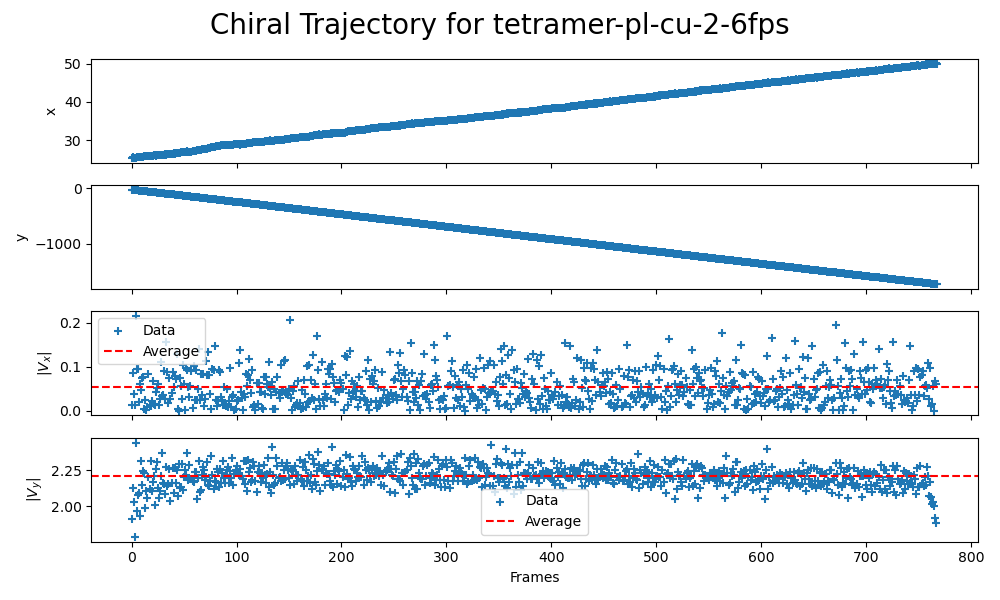

In [11]:
fig, ax = plt.subplots(4,1,sharex='all')

# Calculate the velocities
x_velocity = np.abs(np.diff(link_data['x'])) 
y_velocity = np.abs(np.diff(-link_data['y'])) 

# Calculate average velocities
avg_x_velocity = np.mean(x_velocity)
avg_y_velocity = np.mean(y_velocity)

# Original x displacement plot
ax[0].scatter(link_data['frame'], link_data['x'], marker='+')
ax[0].set_ylabel("x")

# Original y displacement plot
ax[1].scatter(link_data['frame'], -link_data['y'], marker='+')
ax[1].set_ylabel("y")

# New x velocity plot
ax[2].scatter(link_data['frame'][:-1], x_velocity, marker='+', label='Data') 
ax[2].axhline(y=avg_x_velocity, color='r', linestyle='--', label='Average')
ax[2].set_ylabel("$|V_x|$")
ax[2].legend()

# New y velocity plot
ax[3].scatter(link_data['frame'][:-1], y_velocity, marker='+', label='Data')  
ax[3].axhline(y=avg_y_velocity, color='r', linestyle='--', label='Average')
ax[3].set_ylabel("$|V_y|$")
ax[3].legend()

# Now, we only want one x label for all the plots, so we set it for the last subplot
ax[3].set_xlabel("Frames")

fig.suptitle("Chiral Trajectory for " + folder_name, fontsize=20)
plt.tight_layout()
plt.show()